### Under the hood of run_ndmg()

Let's take a closer look at how the `run_ndmg()` method operates under the hood. `run_ndmg()` is our suggested one-click pipeline for reliable connectome estimation from diffusion and structural MRI data. This pipeline makes use of internally exposed modules, and they can be strung together differently if the user wishes to vary their processing technique while performing exploratory analysis. Let's dive in!




We start with importing the things we're going to need:

In [1]:
from argparse import ArgumentParser
from datetime import datetime
from subprocess import Popen, PIPE
import os.path as op
import ndmg.utils as mgu
import ndmg.register as mgr
import ndmg.track as mgt
import ndmg.graph as mgg
import numpy as np
import nibabel as nb

from dipy.reconst.dti import TensorModel, fractional_anisotropy, quantize_evecs
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response)
from dipy.direction import peaks_from_model
from dipy.tracking.eudx import EuDX
from dipy.data import get_sphere, get_data
from dipy.core.gradients import gradient_table

As you know, the `run_ndmg` function is called as follows:

    run_ndmg(dwi, bvals, bvecs, mprage, atlas, mask, labels, outdir)
    
Therefore, we should define some input parameters in our workspace.
Let's pretend the files are the same as in the first example.

In [2]:
dwi = './KKI2009_113_1_DTI.nii'
bvals = './KKI2009_113_1_DTI.bval'
bvecs = './KKI2009_113_1_DTI.bvec'
mprage = './KKI2009_113_1_MPRAGE.nii'
atlas = './MNI152_T1_1mm.nii.gz'
mask = './MNI152_T1_1mm_brain_mask.nii.gz'
labels = ['./desikan.nii.gz']
outdir = '.'

Now, instead of calling the function we're going to go through it step by step...

... Up first, preparing output filenames!

In [3]:
# Create derivative output directories
dwi_name = op.splitext(op.splitext(op.basename(dwi))[0])[0]
cmd = "mkdir -p " + outdir + "/reg_dwi " + outdir + "/tensors " +\
       outdir + "/fibers " + outdir + "/graphs"
p = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True)
p.communicate()

# Graphs are different because of potential for multiple parcellations
label_name = [op.splitext(op.splitext(op.basename(x))[0])[0]
              for x in labels]
for label in label_name:
    p = Popen("mkdir -p " + outdir + "/graphs/" + label,
              stdout=PIPE, stderr=PIPE, shell=True)

# Create derivative output file names
aligned_dwi = outdir + "/reg_dwi/" + dwi_name + "_aligned.nii.gz"
tensors = outdir + "/tensors/" + dwi_name + "_tensors.npz"
fibers = outdir + "/fibers/" + dwi_name + "_fibers.npz"
print "This pipeline will produce the following derivatives..."
print "DTI volume resitered to atlas: " + aligned_dwi
print "Diffusion tensors in atlas space: " + tensors
print "Fiber streamlines in atlas space: " + fibers

# Again, graphs are different
graphs = [outdir + "/graphs/" + x + '/' + dwi_name + "_" + x + ".graphml"
          for x in label_name]
print "Graphs of streamlines downsampled to given labels: " +\
      (", ".join([x for x in graphs]))

This pipeline will produce the following derivatives...
DTI volume resitered to atlas: ./reg_dwi/KKI2009_113_1_DTI_aligned.nii.gz
Diffusion tensors in atlas space: ./tensors/KKI2009_113_1_DTI_tensors.npz
Fiber streamlines in atlas space: ./fibers/KKI2009_113_1_DTI_fibers.npz
Graphs of streamlines downsampled to given labels: ./graphs/desikan/KKI2009_113_1_DTI_desikan.graphml


Great. Now we have some input files defined and stored, and we know where we'll dump outputs.
I'd say we're about ready to start the real stuff!

Let's start by making a gradient table. The gradient table combines the b-values and b-vectors, 
and is used when computing tensors on the diffusion data - a necessary step before making our
connectome.

Also, some DTI volumes contain an "extra" scan at the end so here we toss that out.

In [4]:
print "Generating gradient table..."
dwi1 = outdir + "/" + dwi_name + "_t1.nii.gz"
gtab = mgu.load_bval_bvec(bvals, bvecs, dwi, dwi1)

Generating gradient table...
B-values shape (33,)
         min 0.000000 
         max 700.000000 
B-vectors shape (33, 3)
         min -0.996763 
         max 1.000000 
None


Great! Now we need to align our data. There's no point in doing analysis if you can't compare your
results to anything. How we solve this, is by aligning all of our images to a defined and commonly
used atlas, the MNI152 template, and perform all of our analysis in these coordinates.

Before that alignment we'll do some basic denoising of our dwi image stack. If you don't know, DTI
images are collections of 3D volumes, so essentially this step is aligning many (> 30, or even
\> 100 on high quality data sets) 3D images together. For this reason, this is by far the longest
step in the pipeline and takes often around 20-30 minutes.

In [5]:
# We create some temp files we'll need to use along this process
dwi_name = op.splitext(op.splitext(op.basename(dwi))[0])[0]
mprage_name = op.splitext(op.splitext(op.basename(mprage))[0])[0]
atlas_name = op.splitext(op.splitext(op.basename(atlas))[0])[0]

dwi2 = outdir + "/" + dwi_name + "_t2.nii.gz"
b0 = outdir + "/" + dwi_name + "_b0.nii.gz"
xfm1 = outdir + "/" + dwi_name + "_" + mprage_name + "_xfm.mat"
xfm2 = outdir + "/" + mprage_name + "_" + atlas_name + "_xfm.mat"
xfm3 = outdir + "/" + dwi_name + "_" + atlas_name + "_xfm.mat"

# Align DTI volumes to each other
mgr().align_slices(dwi1, dwi2, np.where(gtab.b0s_mask)[0])

# Loads DTI image in as data and extracts B0 volume
dwi_im = nb.load(dwi2)
b0_im = mgu.get_b0(gtab, dwi_im.get_data())

Executing: eddy_correct ./KKI2009_113_1_DTI_t1.nii.gz ./KKI2009_113_1_DTI_t2.nii.gz [32]


That took a while, but looks like it went off without a hitch!

Now let's take the most-structural-looking scan from out DTI volume (termed B0) and align it to our
structural data, and eventually our atlas. We're getting there!

In [6]:
# Wraps B0 volume in new nifti image
b0_head = dwi_im.get_header()
b0_head.set_data_shape(b0_head.get_data_shape()[0:3])
b0_out = nb.Nifti1Image(b0_im, affine=dwi_im.get_affine(),
                        header=b0_head)
b0_out.update_header()
nb.save(b0_out, b0)

# Algins B0 volume to MPRAGE, and MPRAGE to Atlas
mgr().align(b0, mprage, xfm1)
mgr().align(mprage, atlas, xfm2)

Executing: flirt -in ./KKI2009_113_1_DTI_b0.nii.gz -ref ./KKI2009_113_1_MPRAGE.nii -omat ./KKI2009_113_1_DTI_KKI2009_113_1_MPRAGE_xfm.mat -cost mutualinfo -bins 256 -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180
Executing: flirt -in ./KKI2009_113_1_MPRAGE.nii -ref ./MNI152_T1_1mm.nii.gz -omat ./KKI2009_113_1_MPRAGE_MNI152_T1_1mm_xfm.mat -cost mutualinfo -bins 256 -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180


Now that wasn't nearly as painful. Even got two print statements to keep us company! So we have aligned
the B0 volume to our structural scan, and the structural scan to our atlas... But our image still isn't
in atlas space, right?

Right! We will combine those transforms in sequence, and then apply the registration to our DTI images.

In [7]:
# Combines transforms from previous registrations in proper order
cmd = "convert_xfm -omat " + xfm3 + " -concat " + xfm2 + " " + xfm1
p = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True)
p.communicate()

# Applies combined transform to dwi image volume
mgr().applyxfm(dwi2, atlas, xfm3, aligned_dwi)

Executing: flirt -in ./KKI2009_113_1_DTI_t2.nii.gz -ref ./MNI152_T1_1mm.nii.gz -out ./reg_dwi/KKI2009_113_1_DTI_aligned.nii.gz -init ./KKI2009_113_1_DTI_MNI152_T1_1mm_xfm.mat -interp trilinear -applyxfm


Finally, we're getting somewhere! We have our DTI volume in the atlas space now, so 
let the fun diffusion processing begin.

So, let's not waste any time and generate some tensors! Once we've got them let's use
DiPy's EuDX algorithm to form fiber streamlines.


In [8]:
# Loads image data
img = nb.load(aligned_dwi)
data = img.get_data()

# Loads mask and ensures it's a true binary mask
img = nb.load(mask)
mask = img.get_data()
mask = mask > 0

# Estimates some tensors
model = TensorModel(gtab)
ten = model.fit(data, mask)
sphere = get_sphere('symmetric724')
ind = quantize_evecs(ten.evecs, sphere.vertices)

# Peforms tractography on the tensors
eu = EuDX(a=ten.fa, ind=ind, seeds=1000000,
          odf_vertices=sphere.vertices, a_low=0.1)
tracks = [e for e in eu]

print "Saving tensors and fibers..."
np.savez(tensors, ten)
np.savez(fibers, tracks)

Saving tensors and fibers...


Super cool, we have fibers now! We're just about finished, so let's hurry up and finish this
so we can get out of here early.

All that's left do is generate our graphs for each of our parcellations.

In [9]:
# Generate graphs from streamlines for each parcellation
for idx, label in enumerate(label_name):
    print "Generating graph for " + label + " parcellation..."
    labels_im = nb.load(labels[idx])
    g = mgg(len(np.unique(labels_im.get_data()))-1, labels[idx])
    g.make_graph(tracks)
    g.summary()
    g.save_graph(graphs[idx])

Generating graph for desikan parcellation...
# of Streamlines: 188956
0
25000
50000
75000
100000
125000
150000
175000
Graph attributes: None
Number of nodes: 70
Node attributes: ids
Number of edges: 1184
Edge attributes: weight


And voila! We're done! Congratulations, you've just successfully mapped a brain. Want to see
the produced graph? I suppose we can let you do that...

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


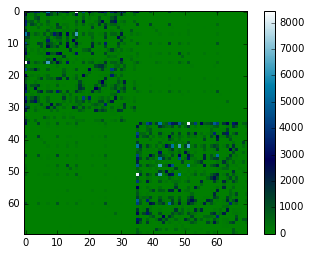

In [10]:
%matplotlib inline
import matplotlib.pylab as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
g1 = g.get_graph()
G1 = g1.get_adjacency(attribute='weight')
G1 = np.asarray(G1.data)

plt.imshow(G1, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()